# Project 1 : Human Activity Recognition

### 프로젝트 제출 가이드
- 제출 기한: 2023년 8월 4일 (금) 자정
- 제출 내용: `4. 구현` 셀에 `LRClassifier` 변수를 구현하고, `Project1.ipynb`를 제출
- 제출 방법: `ta_ml@hcs.snu.ac.kr`로 이메일 제출 (여러 번 제출시 마지막 버전을 사용)
- 메일 제목: `X조 ML Project 1`
- 점수 비중: 10%


### 채점 기준 [총 100점]
1. `5. 테스트` 셀이 잘 실행되어야 합니다. [+100점]
2. `LRClassifier`는 Logistic Regression을 이용해서 분류를 수행해야 합니다. [-100점]
3. 띄어쓰기, 주석, Data Plotting 등 실행과 상관없는 부분은 수정이 가능하고, 실행과 관련된 부분은 `4. 구현` 셀만 수정하여야 합니다. [-50점]


### 참고 사항
1. Project 1에서 성능은 채점 기준에 들어가지 않습니다.
2. `sklearn` 외의 다른 라이브러리를 사용해도 됩니다.

---
## 목차
1. 프로젝트 개요
2. 데이터<br/>
  2.1. 데이터 로드 방법<br/>
  2.2. 데이터 개요<br/>
  2.3. 데이터 샘플 예제<br/>
3. `KNNClassifier` 예제
4. 구현
5. 테스트

### 1. 프로젝트 개요
- 5초간 손목의 가속도계 센서 데이터를 이용해서 그 사람의 행동을 예측하는 분류기를 만듭니다.

<img src="https://gitlab.com/machine-learning-course1/ml-project-samsung-2023-summer/-/raw/master/images/simple_pipeline.png" style='width:70%; margin-bottom:10px'>
<div style='text-align:center; font-weight:bold;'>그림 1. Walking, Running 예제 데이터</div>

### Import libraries

In [1]:
import pickle
from urllib.request import urlopen

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import cross_val_score, LeaveOneGroupOut
%matplotlib inline

### 2. 데이터
#### 2.1. 데이터 로드

In [2]:
def load_data(local=True):
    """
    For colab, use local = False.
    It takes a few minutes to download.
    """
    if local:
        DATA_PATH = 'data/train.pkl'
        with open(DATA_PATH, 'rb') as f:
            df = pickle.load(f)
    else:
        DATA_URL = 'https://gitlab.com/machine-learning-course1/ml-project-samsung-2023-summer/-/raw/master/data/train.pkl?inline=false'
        df = pickle.load(urlopen(DATA_URL))

    X, Y = np.stack(df['Data']), np.stack(df['Motion'])  # np.stack : pandas.Series => np.ndarray
    groups = np.stack(df['Subject'])  # For LeaveOneGroupOut

    return X, Y, groups

In [60]:
def load_data_df(local=True):
    """
    For colab, use local = False.
    It takes a few minutes to download.
    """
    if local:
        DATA_PATH = 'data/train.pkl'
        with open(DATA_PATH, 'rb') as f:
            df = pickle.load(f)
    else:
        DATA_URL = 'https://gitlab.com/machine-learning-course1/ml-project-samsung-2023-summer/-/raw/master/data/train.pkl?inline=false'
        df = pickle.load(urlopen(DATA_URL))

    return df

In [3]:
X, Y, groups = load_data(local=False)

print(X.shape, Y.shape, groups.shape)

(13940, 500, 3) (13940,) (13940,)


#### 2.2. 데이터 개요
- 각 샘플은 `Subject`, `Data`, `Motion` 값으로 이루어져 있습니다.
  - `Subject`: 실험자 ID (`int` 타입)
  - `Data`: (500, 3) 형태의 `numpy array` (`numpy array` 타입)
    - 5초 동안 100Hz로 3축 데이터를 모으면 (500, 3) 형태의 데이터가 됩니다.
  - `Motion`: 실험자의 실제 행동 ( `str` 타입)
    - ex. `walking`, `running`, ...

- `Data` 정보를 가지고 `Motion` 값을 유추해야합니다.
- `Subject`는 Cross Validation에 활용하기 위해 제공됩니다. Cross Validation의 경우 `CrossValidation.ipynb`를 참고해주세요.

#### 2.3. 데이터 샘플 예제

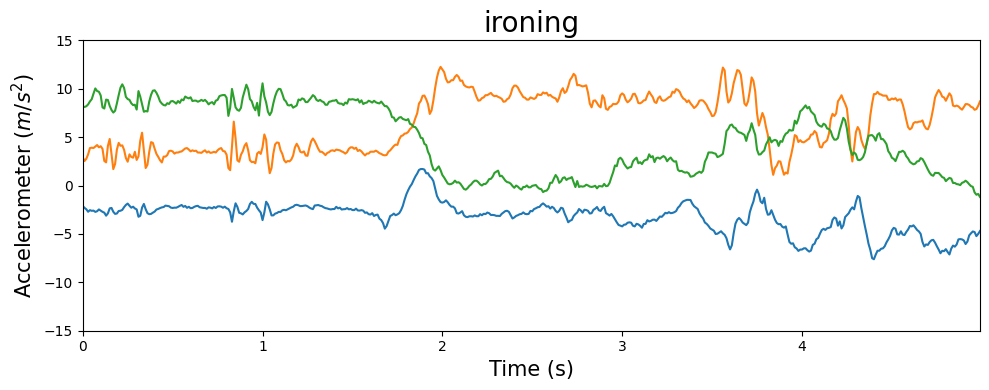

In [ ]:
FPS = 100

X_sample, Y_sample = X[0], Y[0]
time_stamps = np.arange(0, len(X_sample)) / FPS


fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(time_stamps, X_sample)

ax.set_title(Y_sample, fontsize=20)
ax.set_xlabel('Time (s)', fontsize=15)
ax.set_ylabel('Accelerometer ($m/s^2$)', fontsize=15)
ax.set_xlim(min(time_stamps), max(time_stamps))
ax.set_ylim(-15, 15)

fig.tight_layout()
fig.show()

### 3. `KNNClassifier` 예제
- 이 예제는 예시일 뿐이고, 다른 방식으로 구현하셔도 됩니다. 채점기준을 참고해주세요.

```python
import numpy as np
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer


def extract_features_from_a_single_sample(X_sample: np.ndarray) -> np.ndarray:
    """
    Extract features from a single sample

    Parameters
    ----------
    X_sample : array of shape (500, 3)
        100Hz * 5 seconds => 500
        3 axis (x, y, z)  => 3

    Returns
    -------
    features : array with (p,) shape
        Extracted features from X_sample
    """
    X_fft = np.abs(np.fft.fft(X_sample, axis=0))[1:]
    
    mean = np.mean(X_sample, axis=0)
    std = np.std(X_sample, axis=0)
    
    features = np.hstack([mean, std])
    return features


def extract_features_from_multiple_samples(X_samples: np.ndarray) -> np.ndarray:
    """
    Extract features from multiple samples

    Parameters
    ----------
    X_samples : array of shape (n, 500, 3)
        List of data samples

    Returns
    -------
    array of shape (n, p)
        Extracted features from X_samples
    """
    return np.asarray([extract_features_from_a_single_sample(X_sample) for X_sample in X_samples])


# Example Classifier
# You can use python class instance instead of the Pipeline.
KNNClassifier = Pipeline([
    ('feature_extractor', FunctionTransformer(extract_features_from_multiple_samples)),
    ('preprocessor', PCA()),
    ('classifier', KNeighborsClassifier()),
])
```

#### `KNNClassifier` 구현 순서
##### a. `extract_features_from_a_single_sample`
- (500, 3) 크기의 데이터 샘플 하나를 입력받아 특성들을 1D numpy array로 반환합니다.
- 주어진 예제에서는 `mean`, `std` 특성들을 뽑아내고 있습니다.
- 추가적인 특성들을 구현할 때 아래 목록을 참고하실 수 있습니다.
  - Time Domain 특성
    - min, max, amplitude, sum, absolute sum, euclidean norm, mean, absolute mean, mean absolute deviation, variance, standard deviation, zero crossings, auto-correlations, skewness, kurtosis, percentiles, power, root mean square, cross-correlation of axes, ...
  - Frequency Domain 특성
    - energy, entropy, power, spectral centroid, mean, median, standard deviation, dominant frequency, ...

##### b. 전처리기 (Preprocessor) 추가
- a.에서 뽑아낸 특성들을 전처리합니다.
- 주어진 예제에는 `PCA`가 포함되어 있습니다.
- 아래 링크에서 `sklearn`이 제공하는 전처리기 목록을 확인하실 수 있습니다.
  - [`sklearn.preprocessing` documentation](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing).
- `sklearn` 외의 라이브러리를 이용하셔도 됩니다.


##### c. 분류기 튜닝
- a.에서 어떤 특성을 사용할지, b.에서 어떤 전처리기를 사용할지, 전처리기/분류기의 하이퍼파라미터를 어떻게 정할지 등을 바꾸어가며 성능을 높입니다.
- Cross Validation을 이용해서 테스트 결과를 예측하며 하이퍼파라미터를 설정할 수 있습니다.
- 자세한 튜닝 방법은 `CrossValidation.ipynb`를 참고해주세요.

### 4. 구현

## 4.1 데이터 체크

In [4]:
X[:1]

array([[[-2.11548996,  2.91050005,  8.15791035],
        [-2.30843997,  2.5322299 ,  8.11781025],
        [-2.45531988,  2.76169991,  8.19180965],
        ...,
        [-5.22846985,  7.89947987, -0.95008397],
        [-4.99666023,  8.23985004, -0.870785  ],
        [-4.70183992,  8.69009972, -1.17578995]]])

In [20]:
X.shape

(13940, 500, 3)

In [21]:
X[0]

array([[-2.11548996,  2.91050005,  8.15791035],
       [-2.30843997,  2.5322299 ,  8.11781025],
       [-2.45531988,  2.76169991,  8.19180965],
       ...,
       [-5.22846985,  7.89947987, -0.95008397],
       [-4.99666023,  8.23985004, -0.870785  ],
       [-4.70183992,  8.69009972, -1.17578995]])

In [22]:
X[1].shape

(500, 3)

In [23]:
X[2].shape

(500, 3)

In [24]:
X[3].shape

(500, 3)

In [7]:
import pandas as pd

In [9]:
X.shape

(13940, 500, 3)

In [26]:
m, n, r = X.shape
out_arr = np.column_stack((np.repeat(np.arange(m), n), X.reshape(m*n, -1)))

TypeError: ignored

In [11]:
df_x = pd.DataFrame(out_arr)

In [12]:
df_x.head()

0        1        2        3
0  0.0 -2.11549  2.91050  8.15791
1  0.0 -2.30844  2.53223  8.11781
2  0.0 -2.45532  2.76170  8.19181
3  0.0 -2.70996  3.22069  8.37888
4  0.0 -2.54358  3.86718  8.68709

In [13]:
df_x.columns = ['index', 'X', 'Y', 'Z']

index        X        Y        Z
0    0.0 -2.11549  2.91050  8.15791
1    0.0 -2.30844  2.53223  8.11781
2    0.0 -2.45532  2.76170  8.19181
3    0.0 -2.70996  3.22069  8.37888
4    0.0 -2.54358  3.86718  8.68709

In [18]:
df_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6970000 entries, 0 to 6969999
Data columns (total 4 columns):
 #   Column  Dtype  
---  ------  -----  
 0   index   float64
 1   X       float64
 2   Y       float64
 3   Z       float64
dtypes: float64(4)
memory usage: 212.7 MB


In [19]:
df_x.describe()

index             X             Y             Z
count  6.970000e+06  6.970000e+06  6.970000e+06  6.970000e+06
mean   6.969500e+03 -5.055391e+00  2.947588e+00  3.713949e+00
std    4.024132e+03  6.229723e+00  7.358856e+00  3.925825e+00
min    0.000000e+00 -1.453670e+02 -1.043010e+02 -1.014520e+02
25%    3.484750e+03 -9.030820e+00  4.424420e-02  1.314920e+00
50%    6.969500e+03 -5.549160e+00  3.049320e+00  3.487370e+00
75%    1.045425e+04 -1.213780e+00  6.079590e+00  6.687060e+00
max    1.393900e+04  6.091260e+01  1.556990e+02  1.577600e+02

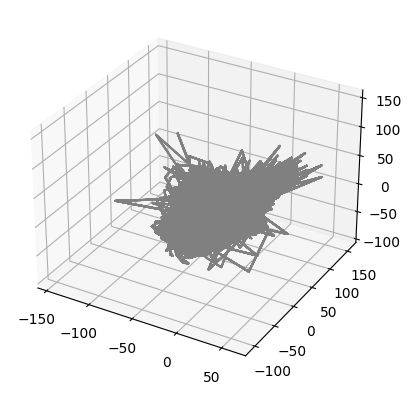

In [25]:
ax = plt.axes(projection='3d')
z = df_x['Z']
x = df_x['X']
y = df_x['Y']
ax.plot3D(x, y, z, 'gray')
plt.show()

In [30]:
df_x['index'].astype('int')

0              0
1              0
2              0
3              0
4              0
           ...  
6969995    13939
6969996    13939
6969997    13939
6969998    13939
6969999    13939
Name: index, Length: 6970000, dtype: int64

In [33]:
df_x[df_x['index'] == 0]

index        X        Y         Z
0      0.0 -2.11549  2.91050  8.157910
1      0.0 -2.30844  2.53223  8.117810
2      0.0 -2.45532  2.76170  8.191810
3      0.0 -2.70996  3.22069  8.378880
4      0.0 -2.54358  3.86718  8.687090
..     ...      ...      ...       ...
495    0.0 -4.74585  8.05478 -0.135144
496    0.0 -4.80529  7.82240 -0.712561
497    0.0 -5.22847  7.89948 -0.950084
498    0.0 -4.99666  8.23985 -0.870785
499    0.0 -4.70184  8.69010 -1.175790

[500 rows x 4 columns]

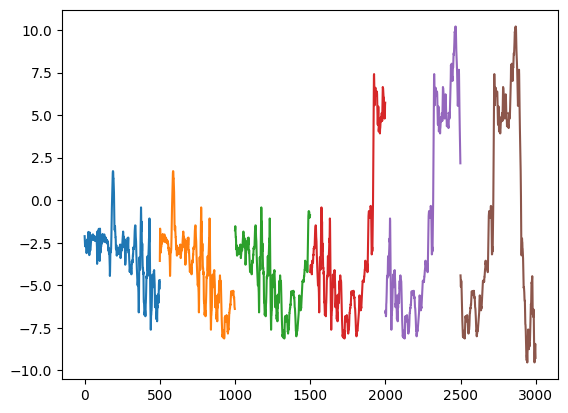

In [35]:
plt.plot(df_x[df_x['index'] == 0]['X'])
plt.plot(df_x[df_x['index'] == 1]['X'])
plt.plot(df_x[df_x['index'] == 2]['X'])
plt.plot(df_x[df_x['index'] == 3]['X'])
plt.plot(df_x[df_x['index'] == 4]['X'])
plt.plot(df_x[df_x['index'] == 5]['X'])

In [36]:
df_y = pd.DataFrame(Y)

In [40]:
df_y.head()

0
0  ironing
1  ironing
2  ironing
3  ironing
4  ironing

In [46]:
df_y.columns = ['motion']

In [47]:
df_y.head()

motion
0  ironing
1  ironing
2  ironing
3  ironing
4  ironing

In [51]:
df_y['motion'].unique()

array(['ironing', 'standing', 'descending stairs', 'lying',
       'ascending stairs', 'sitting', 'walking', 'vacuum cleaning',
       'cycling', 'Nordic walking', 'rope jumping', 'running'],
      dtype=object)

In [53]:
df_y.shape

(13940, 1)

In [54]:
df_x.shape

(6970000, 4)

In [49]:
df = pd.merge(df_x, df_y, left_on='index', right_on='')

In [50]:
df.head()

index        X        Y        Z motion
0    0.0 -2.11549  2.91050  8.15791    NaN
1    0.0 -2.30844  2.53223  8.11781    NaN
2    0.0 -2.45532  2.76170  8.19181    NaN
3    0.0 -2.70996  3.22069  8.37888    NaN
4    0.0 -2.54358  3.86718  8.68709    NaN

In [56]:
X.shape

(13940, 500, 3)

In [57]:
Y.shape

(13940,)

In [58]:
groups.shape

(13940,)

ValueError: ignored

In [62]:
df = load_data_df(local=False)

In [64]:
df.head()

Subject                                               Data   Motion
0        3  [[-2.115489959716797, 2.9105000495910645, 8.15...  ironing
1        3  [[-3.5734200477600098, 3.9679501056671143, 10....  ironing
2        3  [[-1.7668700218200684, 11.98840045928955, 1.08...  ironing
3        3  [[-4.2224202156066895, 9.517740249633789, 2.67...  ironing
4        3  [[-6.610869884490967, 4.498380184173584, 7.815...  ironing

In [65]:
df[['X', 'Y', 'Z']] = pd.DataFrame(df['Data'].to_list(), index=df.index)

ValueError: ignored

In [70]:
df[['X', 'Y', 'Z']] = pd.DataFrame(df['Data'].apply(lambda x: list(zip(*x))).to_list(), index=df.index)

In [71]:
df.head()

Subject                                               Data   Motion  \
0        3  [[-2.115489959716797, 2.9105000495910645, 8.15...  ironing   
1        3  [[-3.5734200477600098, 3.9679501056671143, 10....  ironing   
2        3  [[-1.7668700218200684, 11.98840045928955, 1.08...  ironing   
3        3  [[-4.2224202156066895, 9.517740249633789, 2.67...  ironing   
4        3  [[-6.610869884490967, 4.498380184173584, 7.815...  ironing   

                                                   X  \
0  (-2.115489959716797, -2.3084399700164795, -2.4...   
1  (-3.5734200477600098, -2.779520034790039, -1.6...   
2  (-1.7668700218200684, -1.7025200128555298, -1....   
3  (-4.2224202156066895, -4.04925012588501, -4.02...   
4  (-6.610869884490967, -6.489739894866943, -6.48...   

                                                   Y  \
0  (2.9105000495910645, 2.5322299003601074, 2.761...   
1  (3.9679501056671143, 5.277669906616211, 4.7320...   
2  (11.98840045928955, 11.719900131225586, 11.032...   
3  (9.517740249633789, 9.36083984375, 8.864990234...   
4  (4.498380184173584, 4.4615797996521, 4.5774102...   

                                                   Z  
0  (8.157910346984863, 8.117810249328613, 8.19180...  
1  (10.55720043182373, 9.217619895935059, 8.58176...  
2  (1.0893199443817139, 0.8217750191688538, 0.518...  
3  (2.677340030670166, 2.2571001052856445, 1.9897...  
4  (7.815800189971924, 8.048669815063477, 8.27933...

In [75]:
len(df['X'][0])

500

In [77]:
len(df)

13940

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13940 entries, 0 to 13939
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Subject  13940 non-null  int64 
 1   Data     13940 non-null  object
 2   Motion   13940 non-null  object
 3   X        13940 non-null  object
 4   Y        13940 non-null  object
 5   Z        13940 non-null  object
dtypes: int64(1), object(5)
memory usage: 653.6+ KB


In [80]:
df[['Subject', 'Motion']]

Subject        Motion
0            3       ironing
1            3       ironing
2            3       ironing
3            3       ironing
4            3       ironing
...        ...           ...
13935        9  rope jumping
13936        9  rope jumping
13937        9  rope jumping
13938        9  rope jumping
13939        9  rope jumping

[13940 rows x 2 columns]

In [82]:
df[df['Subject'] == 3]

Subject                                               Data  \
0           3  [[-2.115489959716797, 2.9105000495910645, 8.15...   
1           3  [[-3.5734200477600098, 3.9679501056671143, 10....   
2           3  [[-1.7668700218200684, 11.98840045928955, 1.08...   
3           3  [[-4.2224202156066895, 9.517740249633789, 2.67...   
4           3  [[-6.610869884490967, 4.498380184173584, 7.815...   
...       ...                                                ...   
1689        3  [[-9.697270393371582, 9.589320182800293, 1.632...   
1690        3  [[-9.14072036743164, 5.604549884796143, -2.194...   
1691        3  [[-9.125809669494629, 6.06397008895874, 2.5000...   
1692        3  [[-7.222249984741211, 1.3469699621200562, 2.81...   
1693        3  [[-9.599539756774902, 2.6160099506378174, 2.62...   

               Motion                                                  X  \
0             ironing  (-2.115489959716797, -2.3084399700164795, -2.4...   
1             ironing  (-3.5734200477600098, -2.779520034790039, -1.6...   
2             ironing  (-1.7668700218200684, -1.7025200128555298, -1....   
3             ironing  (-4.2224202156066895, -4.04925012588501, -4.02...   
4             ironing  (-6.610869884490967, -6.489739894866943, -6.48...   
...               ...                                                ...   
1689  vacuum cleaning  (-9.697270393371582, -10.229599952697754, -8.9...   
1690  vacuum cleaning  (-9.14072036743164, -9.856389999389648, -9.881...   
1691  vacuum cleaning  (-9.125809669494629, -9.472490310668945, -10.1...   
1692  vacuum cleaning  (-7.222249984741211, -6.5212202072143555, -6.0...   
1693  vacuum cleaning  (-9.599539756774902, -9.630669593811035, -9.22...   

                                                      Y  \
0     (2.9105000495910645, 2.5322299003601074, 2.761...   
1     (3.9679501056671143, 5.277669906616211, 4.7320...   
2     (11.98840045928955, 11.719900131225586, 11.032...   
3     (9.517740249633789, 9.36083984375, 8.864990234...   
4     (4.498380184173584, 4.4615797996521, 4.5774102...   
...                                                 ...   
1689  (9.589320182800293, 10.511300086975098, 8.8729...   
1690  (5.604549884796143, 9.170680046081543, 13.2167...   
1691  (6.06397008895874, 4.691770076751709, 5.561580...   
1692  (1.3469699621200562, 3.354180097579956, 6.4200...   
1693  (2.6160099506378174, 3.7541399002075195, 4.734...   

                                                      Z  
0     (8.157910346984863, 8.117810249328613, 8.19180...  
1     (10.55720043182373, 9.217619895935059, 8.58176...  
2     (1.0893199443817139, 0.8217750191688538, 0.518...  
3     (2.677340030670166, 2.2571001052856445, 1.9897...  
4     (7.815800189971924, 8.048669815063477, 8.27933...  
...                                                 ...  
1689  (1.6329100131988525, 2.4300599098205566, 2.762...  
1690  (-2.1940500736236572, -2.8710899353027344, -4....  
1691  (2.500080108642578, 1.4988499879837036, 0.5616...  
1692  (2.813920021057129, 3.0100901126861572, 2.5832...  
1693  (2.62007999420166, 2.5772900581359863, 2.23374...  

[1694 rows x 6 columns]

In [83]:
df[df['Motion'] == 'ironing']

Subject                                               Data   Motion  \
0            3  [[-2.115489959716797, 2.9105000495910645, 8.15...  ironing   
1            3  [[-3.5734200477600098, 3.9679501056671143, 10....  ironing   
2            3  [[-1.7668700218200684, 11.98840045928955, 1.08...  ironing   
3            3  [[-4.2224202156066895, 9.517740249633789, 2.67...  ironing   
4            3  [[-6.610869884490967, 4.498380184173584, 7.815...  ironing   
...        ...                                                ...      ...   
12128        8  [[-3.811189889907837, -8.770359992980957, 3.05...  ironing   
12129        8  [[-4.884819984436035, -7.184010028839111, 5.53...  ironing   
12130        8  [[-2.601789951324463, -5.483560085296631, 6.75...  ironing   
12131        8  [[-4.272799968719482, -8.333979606628418, 0.54...  ironing   
12132        8  [[1.8567800521850586, -8.748279571533203, 2.02...  ironing   

                                                       X  \
0      (-2.115489959716797, -2.3084399700164795, -2.4...   
1      (-3.5734200477600098, -2.779520034790039, -1.6...   
2      (-1.7668700218200684, -1.7025200128555298, -1....   
3      (-4.2224202156066895, -4.04925012588501, -4.02...   
4      (-6.610869884490967, -6.489739894866943, -6.48...   
...                                                  ...   
12128  (-3.811189889907837, -3.809580087661743, -4.05...   
12129  (-4.884819984436035, -4.761290073394775, -4.64...   
12130  (-2.601789951324463, -2.7194299697875977, -2.6...   
12131  (-4.272799968719482, -3.930269956588745, -3.65...   
12132  (1.8567800521850586, 2.0385100841522217, 1.983...   

                                                       Y  \
0      (2.9105000495910645, 2.5322299003601074, 2.761...   
1      (3.9679501056671143, 5.277669906616211, 4.7320...   
2      (11.98840045928955, 11.719900131225586, 11.032...   
3      (9.517740249633789, 9.36083984375, 8.864990234...   
4      (4.498380184173584, 4.4615797996521, 4.5774102...   
...                                                  ...   
12128  (-8.770359992980957, -8.921449661254883, -8.61...   
12129  (-7.184010028839111, -7.068719863891602, -7.29...   
12130  (-5.483560085296631, -5.521629810333252, -5.48...   
12131  (-8.333979606628418, -9.13131046295166, -9.820...   
12132  (-8.748279571533203, -8.827289581298828, -9.36...   

                                                       Z  
0      (8.157910346984863, 8.117810249328613, 8.19180...  
1      (10.55720043182373, 9.217619895935059, 8.58176...  
2      (1.0893199443817139, 0.8217750191688538, 0.518...  
3      (2.677340030670166, 2.2571001052856445, 1.9897...  
4      (7.815800189971924, 8.048669815063477, 8.27933...  
...                                                  ...  
12128  (3.0530900955200195, 3.1305999755859375, 3.626...  
12129  (5.533339977264404, 5.804210186004639, 5.99918...  
12130  (6.754909992218018, 6.637810230255127, 6.75434...  
12131  (0.5430279970169067, 0.7817729711532593, 0.287...  
12132  (2.021790027618408, 1.8323400020599365, 1.4484...  

[1834 rows x 6 columns]

In [88]:
for i in df[df['Motion'] == 'ironing']['X'][0]:
  print(i)

-2.115489959716797
-2.3084399700164795
-2.455319881439209
-2.7099599838256836
-2.5435800552368164
-2.610869884490967
-2.5910699367523193
-2.722450017929077
-2.6551599502563477
-2.470489978790283
-2.5964300632476807
-2.7166600227355957
-2.8050498962402344
-3.1141300201416016
-2.876729965209961
-2.3640100955963135
-2.314340114593506
-2.7122600078582764
-2.9285800457000732
-2.891429901123047
-2.6304800510406494
-2.605870008468628
-2.5179901123046875
-2.2322499752044678
-2.0056800842285156
-1.8652100563049316
-2.089289903640747
-2.2921299934387207
-2.1859800815582275
-2.3693299293518066
-2.4681599140167236
-3.2302699089050293
-3.1254899501800537
-2.278549909591675
-1.9026700258255005
-2.441580057144165
-2.8561999797821045
-2.9619300365448
-2.9309298992156982
-2.803380012512207
-2.6929399967193604
-2.479300022125244
-2.419219970703125
-2.3256399631500244
-2.2596800327301025
-2.2229700088500977
-2.0731499195098877
-2.1018500328063965
-2.1393799781799316
-2.2809200286865234
-2.317899942398071

In [131]:
df['Motion'].unique()

array(['ironing', 'standing', 'descending stairs', 'lying',
       'ascending stairs', 'sitting', 'walking', 'vacuum cleaning',
       'cycling', 'Nordic walking', 'rope jumping', 'running'],
      dtype=object)

# 그래프로 확인

## 1. ironing

KeyError: ignored

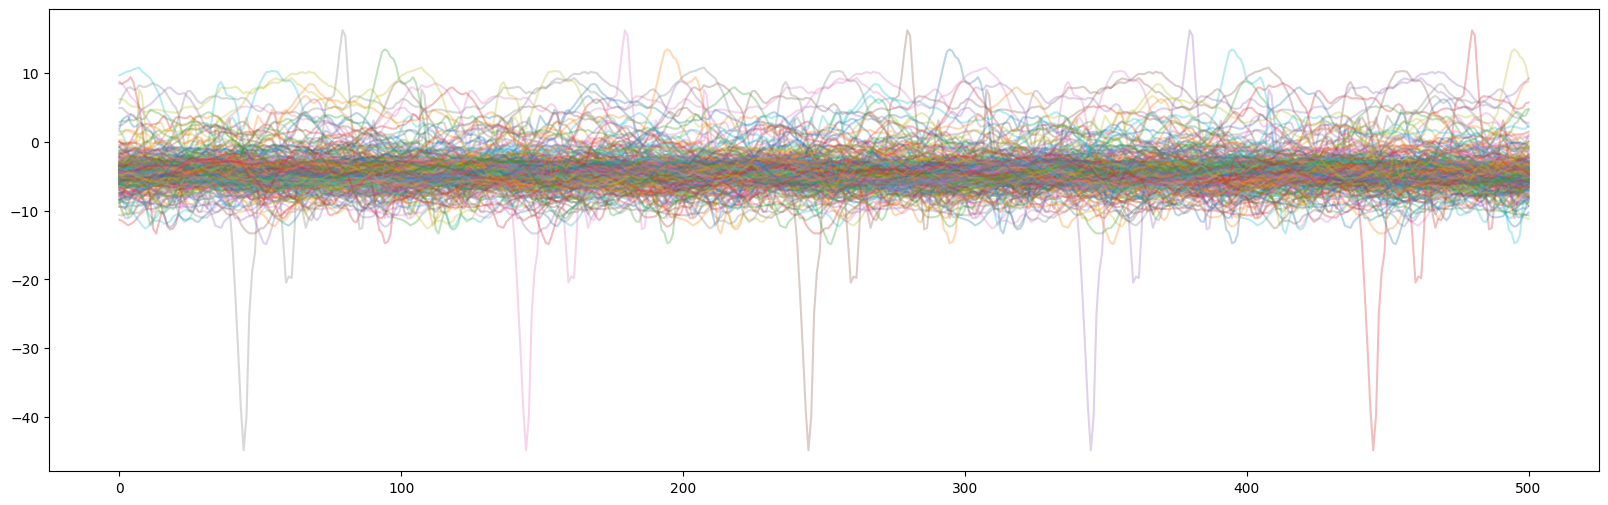

In [130]:
plt.figure(figsize=(20, 6))
for i in range(len(df['X'])):
  data = list(df[df['Motion'] == 'ironing']['X'][i])
  index_data = np.linspace(0, len(data), len(data))
  plt.plot(index_data, data, alpha=0.3)

plt.title('A')
plt.show()


KeyError: ignored

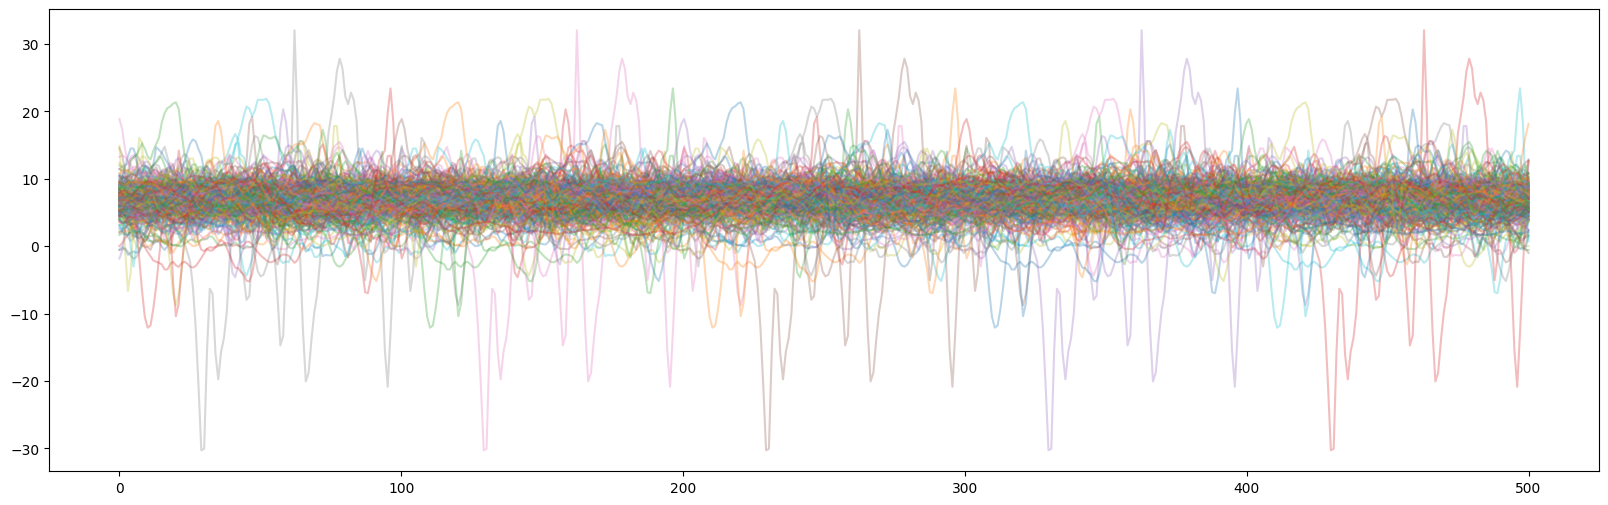

In [136]:
plt.figure(figsize=(20, 6))
for i in range(len(df['Y'])):
  data = list(df[df['Motion'] == 'ironing']['Y'][i])
  index_data = np.linspace(0, len(data), len(data))
  plt.plot(index_data, data, alpha=0.3)

plt.title('A')
plt.show()


KeyError: ignored

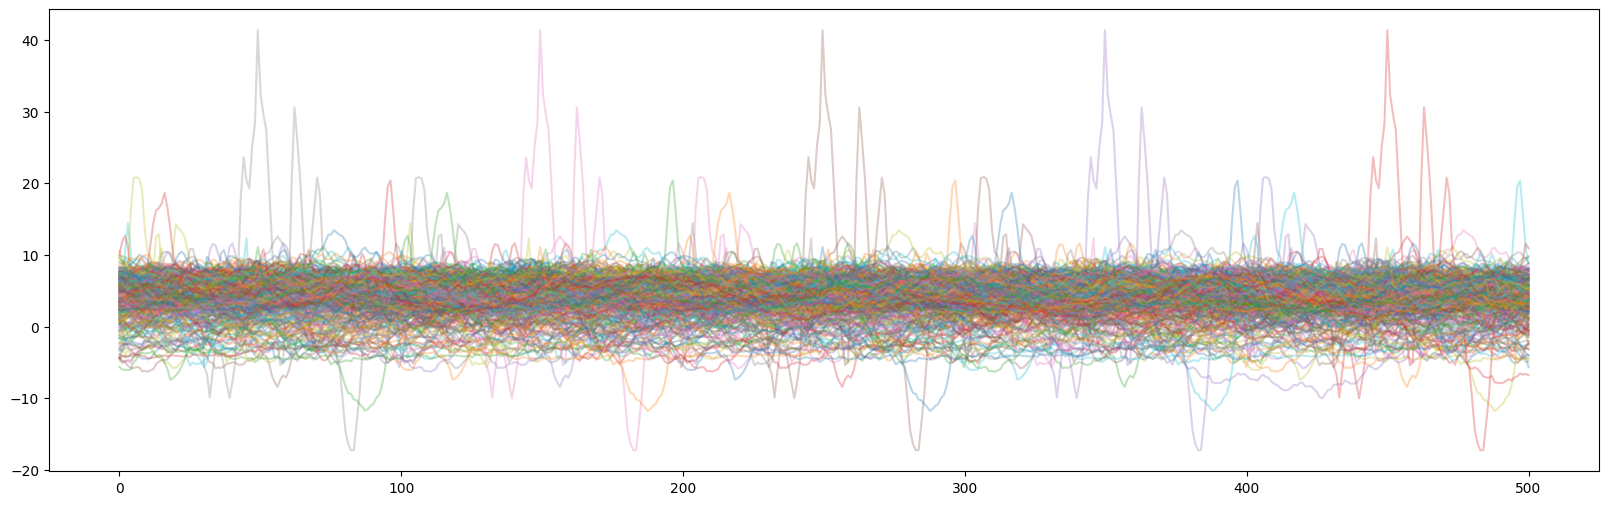

In [137]:
plt.figure(figsize=(20, 6))
for i in range(len(df['Z'])):
  data = list(df[df['Motion'] == 'ironing']['Z'][i])
  index_data = np.linspace(0, len(data), len(data))
  plt.plot(index_data, data, alpha=0.3)

plt.title('A')
plt.show()


In [139]:
df['Motion'].unique()

array(['ironing', 'standing', 'descending stairs', 'lying',
       'ascending stairs', 'sitting', 'walking', 'vacuum cleaning',
       'cycling', 'Nordic walking', 'rope jumping', 'running'],
      dtype=object)

KeyError: ignored

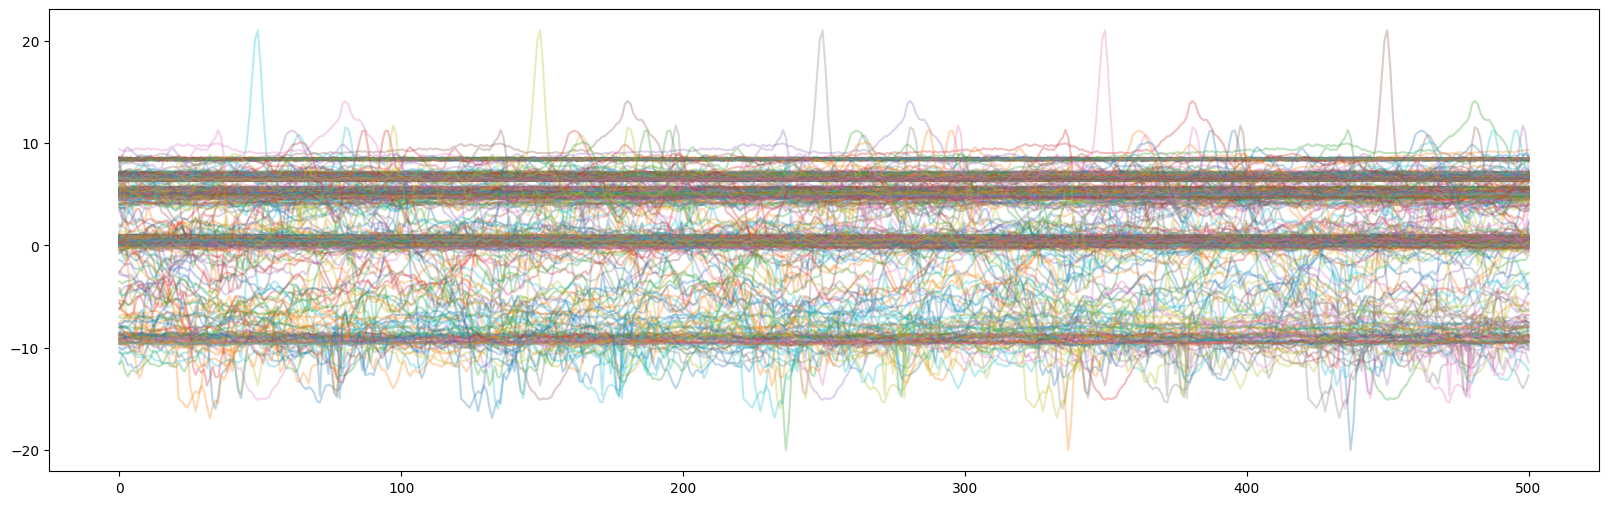

In [155]:
plt.figure(figsize=(20, 6))
target = df[df['Motion'] == 'lying']['X'].reset_index()['X']
for i in range(len(df['X']) - 1):
  data = list(target[i])
  index_data = np.linspace(0, len(data), len(data))
  plt.plot(index_data, data, alpha=0.3)

plt.title('A')
plt.show()


KeyError: ignored

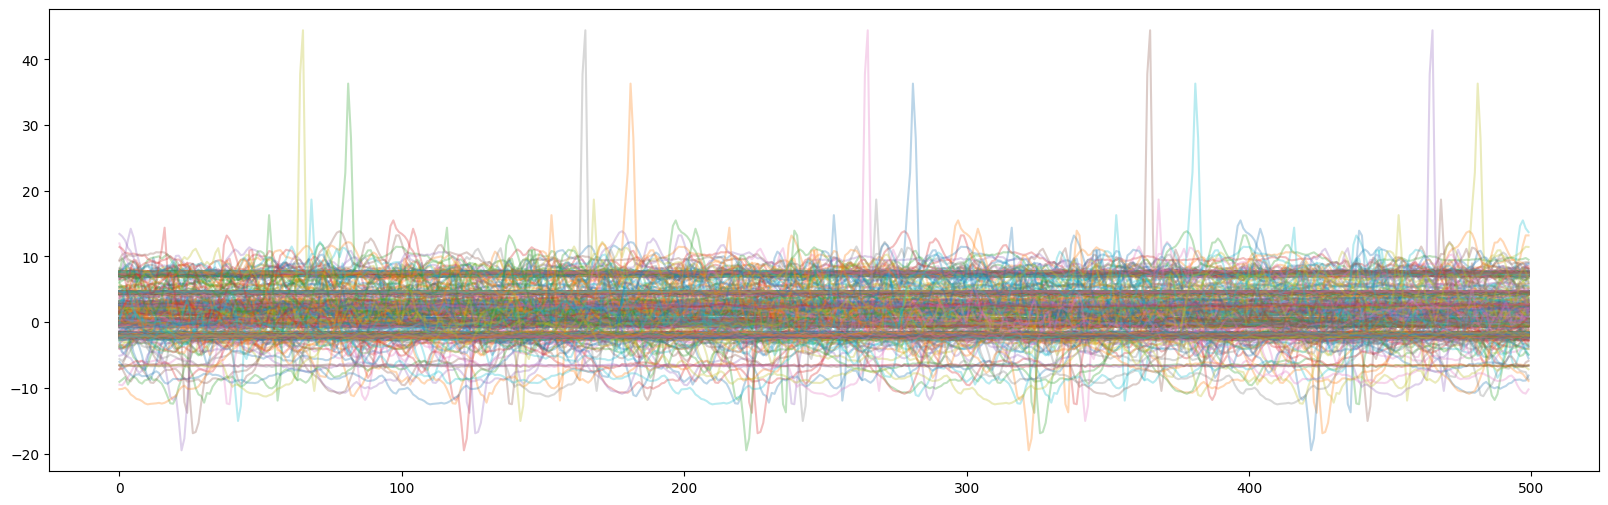

In [162]:
plt.figure(figsize=(20, 6))
target = df[df['Motion'] == 'lying']['Y'].reset_index()['Y']
for i in range(0, len(df['X'])):
  data = list(target[i])
  index_data = np.linspace(0, len(data) - 1, len(data))
  plt.plot(index_data, data, alpha=0.3)

plt.title('A')
plt.show()


KeyError: ignored

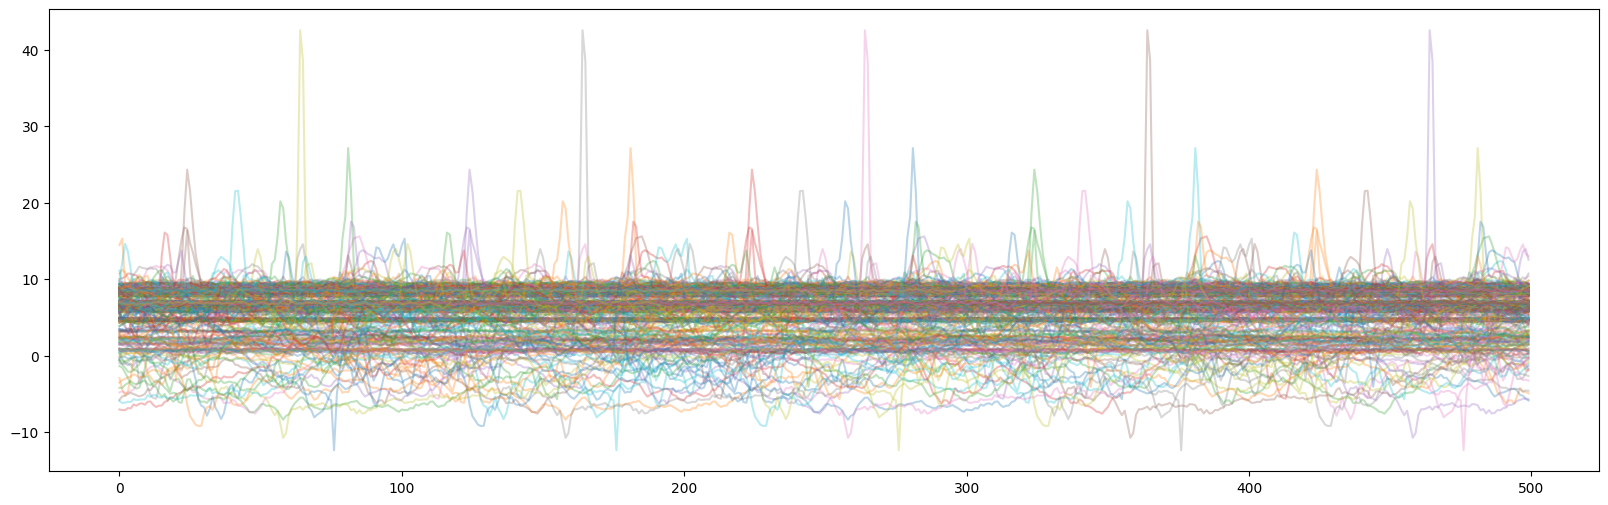

In [163]:
plt.figure(figsize=(20, 6))
target = df[df['Motion'] == 'lying']['Z'].reset_index()['Z']
for i in range(0, len(df['X'])):
  data = list(target[i])
  index_data = np.linspace(0, len(data) - 1, len(data))
  plt.plot(index_data, data, alpha=0.3)

plt.title('A')
plt.show()


In [153]:
df[df['Motion'] == 'lying']['X'].reset_index()['X']

0       (-1.4310499429702759, -1.5747100114822388, -1....
1       (0.3839460015296936, 0.12690100073814392, 0.06...
2       (-4.213009834289551, -5.026130199432373, -4.77...
3       (-5.368430137634277, -5.445350170135498, -5.48...
4       (-2.8343698978424072, -2.9402599334716797, -2....
                              ...                        
1387    (6.491970062255859, 6.448820114135742, 6.45497...
1388    (6.5707502365112305, 6.491970062255859, 6.6002...
1389    (6.672359943389893, 6.640719890594482, 6.52975...
1390    (3.5454299449920654, 3.674139976501465, 3.6663...
1391    (-0.3133159875869751, -0.2792710065841675, -0....
Name: X, Length: 1392, dtype: object

In [143]:
df.describe()

Subject
count  13940.000000
mean       5.662769
std        1.659641
min        3.000000
25%        4.000000
50%        6.000000
75%        7.000000
max        9.000000

In [144]:
df.head()

Subject                                               Data   Motion  \
0        3  [[-2.115489959716797, 2.9105000495910645, 8.15...  ironing   
1        3  [[-3.5734200477600098, 3.9679501056671143, 10....  ironing   
2        3  [[-1.7668700218200684, 11.98840045928955, 1.08...  ironing   
3        3  [[-4.2224202156066895, 9.517740249633789, 2.67...  ironing   
4        3  [[-6.610869884490967, 4.498380184173584, 7.815...  ironing   

                                                   X  \
0  (-2.115489959716797, -2.3084399700164795, -2.4...   
1  (-3.5734200477600098, -2.779520034790039, -1.6...   
2  (-1.7668700218200684, -1.7025200128555298, -1....   
3  (-4.2224202156066895, -4.04925012588501, -4.02...   
4  (-6.610869884490967, -6.489739894866943, -6.48...   

                                                   Y  \
0  (2.9105000495910645, 2.5322299003601074, 2.761...   
1  (3.9679501056671143, 5.277669906616211, 4.7320...   
2  (11.98840045928955, 11.719900131225586, 11.032...   
3  (9.517740249633789, 9.36083984375, 8.864990234...   
4  (4.498380184173584, 4.4615797996521, 4.5774102...   

                                                   Z  
0  (8.157910346984863, 8.117810249328613, 8.19180...  
1  (10.55720043182373, 9.217619895935059, 8.58176...  
2  (1.0893199443817139, 0.8217750191688538, 0.518...  
3  (2.677340030670166, 2.2571001052856445, 1.9897...  
4  (7.815800189971924, 8.048669815063477, 8.27933...

In [146]:
df[df['Motion'] == 'lying']

Subject                                               Data Motion  \
529          3  [[-1.4310499429702759, 5.405879974365234, 7.77...  lying   
530          3  [[0.3839460015296936, 4.028749942779541, 8.114...  lying   
531          3  [[-4.213009834289551, 6.309510231018066, 0.340...  lying   
532          3  [[-5.368430137634277, 7.238870143890381, -7.03...  lying   
533          3  [[-2.8343698978424072, 6.589439868927002, 7.36...  lying   
...        ...                                                ...    ...   
12958        8  [[6.491970062255859, -2.1011300086975098, 6.87...  lying   
12959        8  [[6.5707502365112305, -2.025160074234009, 6.95...  lying   
12960        8  [[6.672359943389893, -2.369839906692505, 6.690...  lying   
12961        8  [[3.5454299449920654, -6.036369800567627, 5.50...  lying   
12962        8  [[-0.3133159875869751, -10.202899932861328, 2....  lying   

                                                       X  \
529    (-1.4310499429702759, -1.5747100114822388, -1....   
530    (0.3839460015296936, 0.12690100073814392, 0.06...   
531    (-4.213009834289551, -5.026130199432373, -4.77...   
532    (-5.368430137634277, -5.445350170135498, -5.48...   
533    (-2.8343698978424072, -2.9402599334716797, -2....   
...                                                  ...   
12958  (6.491970062255859, 6.448820114135742, 6.45497...   
12959  (6.5707502365112305, 6.491970062255859, 6.6002...   
12960  (6.672359943389893, 6.640719890594482, 6.52975...   
12961  (3.5454299449920654, 3.674139976501465, 3.6663...   
12962  (-0.3133159875869751, -0.2792710065841675, -0....   

                                                       Y  \
529    (5.405879974365234, 5.143819808959961, 4.50119...   
530    (4.028749942779541, 4.335639953613281, 4.71762...   
531    (6.309510231018066, 7.143929958343506, 7.85836...   
532    (7.238870143890381, 7.42848014831543, 7.618460...   
533    (6.589439868927002, 7.084529876708984, 7.46359...   
...                                                  ...   
12958  (-2.1011300086975098, -1.9128199815750122, -1....   
12959  (-2.025160074234009, -2.1011300086975098, -2.0...   
12960  (-2.369839906692505, -2.254390001296997, -2.10...   
12961  (-6.036369800567627, -6.573379993438721, -7.10...   
12962  (-10.202899932861328, -10.166299819946289, -9....   

                                                       Z  
529    (7.774869918823242, 8.043009757995605, 8.04059...  
530    (8.11460018157959, 8.263669967651367, 8.492329...  
531    (0.3405739963054657, -0.4056810140609741, -0.9...  
532    (-7.0309600830078125, -7.109720230102539, -7.1...  
533    (7.364980220794678, 7.477190017700195, 7.43743...  
...                                                  ...  
12958  (6.879720211029053, 6.685999870300293, 6.87877...  
12959  (6.957610130310059, 6.879720211029053, 6.72727...  
12960  (6.690889835357666, 6.843969821929932, 6.88028...  
12961  (5.501800060272217, 4.966710090637207, 4.85293...  
12962  (2.9178900718688965, 2.802809953689575, 2.4969...  

[1392 rows x 6 columns]

In [115]:
data.shape

AttributeError: ignored

In [116]:
index_data.shape

(50,)

In [113]:
len(data)

500

In [112]:
data

[-2.115489959716797,
 -2.3084399700164795,
 -2.455319881439209,
 -2.7099599838256836,
 -2.5435800552368164,
 -2.610869884490967,
 -2.5910699367523193,
 -2.722450017929077,
 -2.6551599502563477,
 -2.470489978790283,
 -2.5964300632476807,
 -2.7166600227355957,
 -2.8050498962402344,
 -3.1141300201416016,
 -2.876729965209961,
 -2.3640100955963135,
 -2.314340114593506,
 -2.7122600078582764,
 -2.9285800457000732,
 -2.891429901123047,
 -2.6304800510406494,
 -2.605870008468628,
 -2.5179901123046875,
 -2.2322499752044678,
 -2.0056800842285156,
 -1.8652100563049316,
 -2.089289903640747,
 -2.2921299934387207,
 -2.1859800815582275,
 -2.3693299293518066,
 -2.4681599140167236,
 -3.2302699089050293,
 -3.1254899501800537,
 -2.278549909591675,
 -1.9026700258255005,
 -2.441580057144165,
 -2.8561999797821045,
 -2.9619300365448,
 -2.9309298992156982,
 -2.803380012512207,
 -2.6929399967193604,
 -2.479300022125244,
 -2.419219970703125,
 -2.3256399631500244,
 -2.2596800327301025,
 -2.2229700088500977,
 -2.07

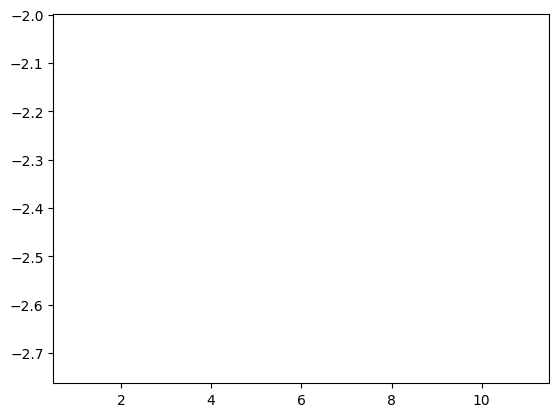

In [96]:
plt.plot(1, -2.182080030441284, label='1')
plt.plot(2, -2.7211201190948486)
plt.plot(3, -2.727790117263794)
plt.plot(4, -2.5588901042938232)
plt.plot(5, -2.5078999996185303)
plt.plot(6, -2.5539801120758057)
plt.plot(7, -2.4529099464416504)
plt.plot(8, -2.3411500453948975)
plt.plot(9, -2.2615599632263184)
plt.plot(10, -2.1937499046325684)
plt.plot(11, -2.032710075378418)
plt.show()

In [38]:
df = pd.concat([df_x, df_y])

In [39]:
df.head()

index        X        Y        Z    0
0    0.0 -2.11549  2.91050  8.15791  NaN
1    0.0 -2.30844  2.53223  8.11781  NaN
2    0.0 -2.45532  2.76170  8.19181  NaN
3    0.0 -2.70996  3.22069  8.37888  NaN
4    0.0 -2.54358  3.86718  8.68709  NaN

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
############################################################
# Implement your own LRClassifier in this cell
import numpy as np
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, QuantileTransformer, RobustScaler
from sklearn.linear_model import LogisticRegression


def extract_features_from_a_single_sample(X_sample: np.ndarray) -> np.ndarray:
    """
    Extract features from a single sample

    Parameters
    ----------
    X_sample : array of shape (500, 3)
        100Hz * 5 seconds => 500
        3 axis (x, y, z)  => 3

    Returns
    -------
    features : array with (p,) shape
        Extracted features from X_sample
    """
    X_fft = np.abs(np.fft.fft(X_sample, axis=0))[1:]

    mean = np.mean(X_sample, axis=0)
    std = np.std(X_sample, axis=0)

    features = np.hstack([mean, std])
    return features


def extract_features_from_multiple_samples(X_samples: np.ndarray) -> np.ndarray:
    """
    Extract features from multiple samples

    Parameters
    ----------
    X_samples : array of shape (n, 500, 3)
        List of data samples

    Returns
    -------
    array of shape (n, p)
        Extracted features from X_samples
    """
    return np.asarray([extract_features_from_a_single_sample(X_sample) for X_sample in X_samples])


# Example Classifier
# You can use python class instance instead of the Pipeline.


############################################################

In [ ]:
LRClassifier = Pipeline([
    ('feature_extractor', FunctionTransformer(extract_features_from_multiple_samples)),
    ('normalizer', MinMaxScaler()),
    ('preprocessor', PCA()),
    ('그냥해봄', QuantileTransformer()),
    ('classifier', LogisticRegression(max_iter=1000, solver='lbfgs')),
])

### 5. Cross-validation with subjects

In [ ]:
X, Y, groups = load_data(local=False)

# Scoring
scores = cross_val_score(
    LRClassifier,
    X, Y, groups=groups,
    scoring='f1_macro',
    cv=LeaveOneGroupOut())
print(np.mean(scores))

0.40971132774003316


In [ ]:
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, QuantileTransformer, RobustScaler

LRClassifier = Pipeline([
    ('feature_extractor', FunctionTransformer(extract_features_from_multiple_samples)),
    ('normalizer', RobustScaler()),
    ('preprocessor', PCA()),
    ('classifier', LogisticRegression(max_iter=1000, solver='lbfgs')),
])

X, Y, groups = load_data(local=False)

# Scoring
scores = cross_val_score(
    LRClassifier,
    X, Y, groups=groups,
    scoring='f1_macro',
    cv=LeaveOneGroupOut())
print(np.mean(scores))

0.443528179696479


In [ ]:
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, QuantileTransformer, RobustScaler, MaxAbsScaler

LRClassifier = Pipeline([
    ('feature_extractor', FunctionTransformer(extract_features_from_multiple_samples)),
    ('normalizer', MaxAbsScaler()),
    ('preprocessor', PCA()),
    ('classifier', LogisticRegression(max_iter=1000, solver='lbfgs')),
])

X, Y, groups = load_data(local=False)

# Scoring
scores = cross_val_score(
    LRClassifier,
    X, Y, groups=groups,
    scoring='f1_macro',
    cv=LeaveOneGroupOut())
print(np.mean(scores))

0.41847161176329334


In [ ]:

def extract_features_from_a_single_sample(X_sample: np.ndarray) -> np.ndarray:
    """
    Extract features from a single sample

    Parameters
    ----------
    X_sample : array of shape (500, 3)
        100Hz * 5 seconds => 500
        3 axis (x, y, z)  => 3

    Returns
    -------
    features : array with (p,) shape
        Extracted features from X_sample
    """
    X_fft = np.abs(np.fft.fft(X_sample, axis=0))[1:]

    mean = np.mean(X_sample, axis=0)
    std = np.std(X_sample, axis=0)
    min = np.min(X_sample, axis=0)
    max = np.max(X_sample, axis=0)

    features = np.hstack([mean, std, min, max])
    return features

from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, QuantileTransformer, RobustScaler, MaxAbsScaler

LRClassifier = Pipeline([
    ('feature_extractor', FunctionTransformer(extract_features_from_multiple_samples)),
    ('normalizer', RobustScaler()),
    ('preprocessor', PCA()),
    ('classifier', LogisticRegression(max_iter=1000, solver='lbfgs')),
])

X, Y, groups = load_data(local=False)

# Scoring
scores = cross_val_score(
    LRClassifier,
    X, Y, groups=groups,
    scoring='f1_macro',
    cv=LeaveOneGroupOut())
print(np.mean(scores))

0.46055809564044276
